# Import libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

2024-08-25 13:31:25.714990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 13:31:25.715149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 13:31:25.844134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Variables

In [2]:
height = 256
width = 256
image_size = (height,width)

batch_size = 16
lr = 0.0001
# epoch_size = 10
# epoch_size = 20
model_path_10 = '/kaggle/working/segmentation_model_10.keras'
model_path_20 = '/kaggle/working/segmentation_model_20.keras'

# Building the U-Net

In [3]:
def conv_block(inputs, num_filters):
    """Convolutional Block with two convolutions, batch normalization, and ReLU activation."""
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    """Encoder Block with a convolutional block followed by max pooling."""
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder Block with transposed convolution, concatenation with skip features, and a convolutional block."""
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_unet(input_shape):
    """Builds the U-Net model by stacking encoder, bottleneck, and decoder blocks."""
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # bottleneck layer

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-NET")
    return model

In [5]:
input_shape = (256,256,3)
model = build_unet(input_shape)
model.summary()

Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Metrics

In [6]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# def iou(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     union = total - intersection
#     return (intersection + smooth) / (union + smooth)

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [8]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset('/kaggle/input/segmentation-data/aryas')

In [10]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 1092 - 1092
Valid: 364 - 364
Test : 364 - 364


# Data augmentation and preprocessing

In [11]:
def augment(x, y):
    # Randomly flip the image and mask horizontally
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)

    # Randomly flip the image and mask vertically
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)

    # Randomly rotate the image and mask
    angle = tf.random.uniform((), minval=-0.1, maxval=0.1)  # rotation angle in radians
    x = tf.image.rot90(x, k=int(angle / (np.pi / 2)))  # rotate by 90 degree multiples
    y = tf.image.rot90(y, k=int(angle / (np.pi / 2)))

    # Random zoom
    scale = tf.random.uniform((), minval=0.9, maxval=1.1)
    new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)

    x = tf.image.resize(x, (new_height, new_width))
    y = tf.image.resize(y, (new_height, new_width))

    x = tf.image.resize_with_crop_or_pad(x, height, width)
    y = tf.image.resize_with_crop_or_pad(y, height, width)

    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (width, height))  
    x = x / 255.0             
    x = x.astype(np.float32)    
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

def tf_dataset(X, Y, batch=2, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size, augment_data=True)
val_dataset = tf_dataset(valid_x, valid_y, batch=batch_size, augment_data=False)

# Compile model

In [13]:
model.compile(loss=dice_loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy',dice_coef])

# Callbacks

In [14]:
callbacks = [
        ModelCheckpoint(model_path_20, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

# Model training

In [15]:
history = model.fit(train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks)

Epoch 1/20


2024-08-25 13:36:23.637790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-08-25 13:36:23.638049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-08-25 13:36:23.638192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-08-25 13:36:23.638427: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-08-25 13:36:23.638454: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-08-25 13:36:23.638470: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-08-25 13:36:23.638482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-08-25 13:36:23.638494: E ex

68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6506 - dice_coef: 0.1860 - loss: 0.8140

2024-08-25 13:37:52.254421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.24577, expected 2.80959
2024-08-25 13:37:52.254494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.17396, expected 2.73778
2024-08-25 13:37:52.254875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.15611, expected 2.41005
2024-08-25 13:37:52.254920: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 3.84262, expected 3.09657
2024-08-25 13:37:52.254933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.59187, expected 3.84581
2024-08-25 13:37:52.254944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 5.43123, expected 4.68518
2024-08-25 13:37:52.254958: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 5.1009, expected 4.35484
2024-08-25 13:37:52.254971: E exte

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6527 - dice_coef: 0.1868 - loss: 0.8132

2024-08-25 13:38:21.060185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.59143, expected 2.72011
2024-08-25 13:38:21.060246: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.91216, expected 3.04084
2024-08-25 13:38:21.060255: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.94757, expected 4.07625
2024-08-25 13:38:21.060263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.44113, expected 4.56981
2024-08-25 13:38:21.060271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.12543, expected 4.25411
2024-08-25 13:38:21.060279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.68197, expected 4.81064
2024-08-25 13:38:21.060287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.63124, expected 4.75992
2024-08-25 13:38:21.060295: E external/local_xla/xla/se


Epoch 1: val_loss improved from inf to 0.91382, saving model to /kaggle/working/segmentation_model_20.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6548 - dice_coef: 0.1876 - loss: 0.8124 - val_accuracy: 0.9510 - val_dice_coef: 0.0863 - val_loss: 0.9138 - learning_rate: 1.0000e-04
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9324 - dice_coef: 0.3540 - loss: 0.6460
Epoch 2: val_loss improved from 0.91382 to 0.84227, saving model to /kaggle/working/segmentation_model_20.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - accuracy: 0.9326 - dice_coef: 0.3543 - loss: 0.6457 - val_accuracy: 0.8082 - val_dice_coef: 0.1580 - val_loss: 0.8423 - learning_rate: 1.0000e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9533 - dice_coef: 0.4325 - loss: 0.5675
Epoch 3: val_loss did not improve from 0.84227
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 410ms/step - accuracy: 0.9534 - dice_coef: 0.4327 - loss: 0.5673 - val_accuracy: 0.9491 - val_dice_coef: 0.1515

# Function for plotting learning curves

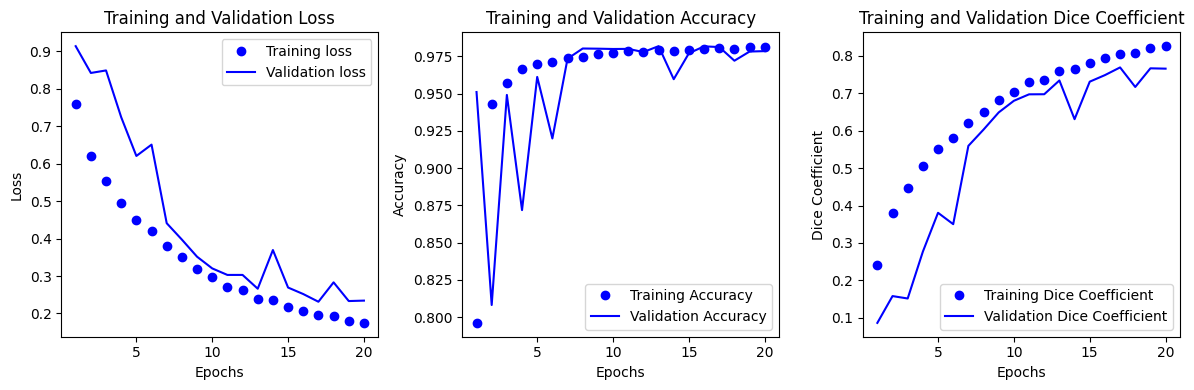

In [16]:
# Extract data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation dice coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, dice_coef, 'bo', label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coef, 'b', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set

In [17]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size, augment_data=False)

In [18]:
model.evaluate(test_dataset)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9788 - dice_coef: 0.7741 - loss: 0.2259


[0.22729052603244781, 0.9783558249473572, 0.7725645303726196]

# Evaluation via qualitative analysis

In [21]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((height, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [22]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) 
    image = cv2.resize(image, (width, height))       
    x = image/255.0                        
    x = np.expand_dims(x, axis=0)          

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    results_path = '/kaggle/working'
    save_image_path = os.path.join(results_path, name)
    save_results(image, mask, y_pred, save_image_path)

100%|██████████| 364/364 [00:29<00:00, 12.29it/s]


# Results of segmentation

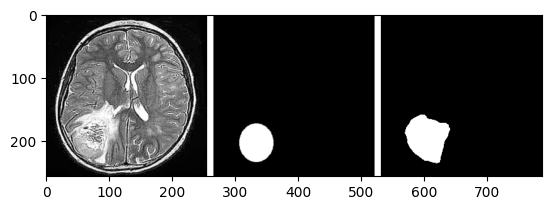

In [23]:
img = cv2.imread('/kaggle/working/y473.png')
plt.imshow(img)

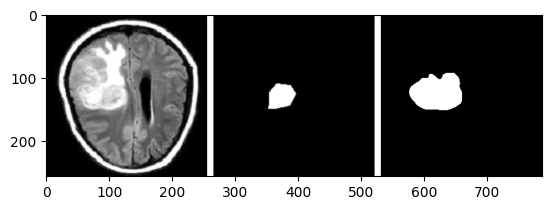

In [24]:
img = cv2.imread('/kaggle/working/fy189.png')
plt.imshow(img)

# Save the results in a zip file

In [25]:
# Define the path to the results folder
results_dir = 'results'

# Create the directory if it doesn't exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [26]:
import shutil
import glob

# Get a list of all .png files in the current directory
png_files = glob.glob('*.png')

# Move each file to the results directory
for file in png_files:
    shutil.move(file, results_dir)

In [27]:
shutil.make_archive('/kaggle/working/results', 'zip', '/kaggle/working/results')

'/kaggle/working/results.zip'

# Information on dataset

In [2]:
# Paths to your dataset folders
data_path = '/kaggle/input/segmentation-data/aryas'
images_path = os.path.join(data_path, 'images')
masks_path = os.path.join(data_path, 'masks')

# Parameters
image_size = (256, 256)

In [3]:
def load_images_and_masks(images_path, masks_path, image_size):
    images = []
    masks = []
    
    image_filenames = sorted(os.listdir(images_path))
    mask_filenames = sorted(os.listdir(masks_path))
    
    for image_filename, mask_filename in zip(image_filenames, mask_filenames):
        image_path = os.path.join(images_path, image_filename)
        mask_path = os.path.join(masks_path, mask_filename)

        # Load image and mask
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if image and mask are correctly loaded
        if image is None:
            print(f"Error loading image: {image_path}")
            continue
        if mask is None:
            print(f"Error loading mask: {mask_path}")
            continue

        # Resize image and mask
        image = cv2.resize(image, image_size)
        mask = cv2.resize(mask, image_size)
        
        # Normalize image and mask
        image = image / 255.0
        mask = mask / 255.0
        
        # Expand dimensions to match U-Net input shape (256, 256, 1)
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Display some sample images and their corresponding masks
def display_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.show()

In [4]:
# Load the images and masks
images, masks = load_images_and_masks(images_path, masks_path, image_size)

print(images.shape)
print(masks.shape)

(1820, 256, 256, 1)
(1820, 256, 256, 1)


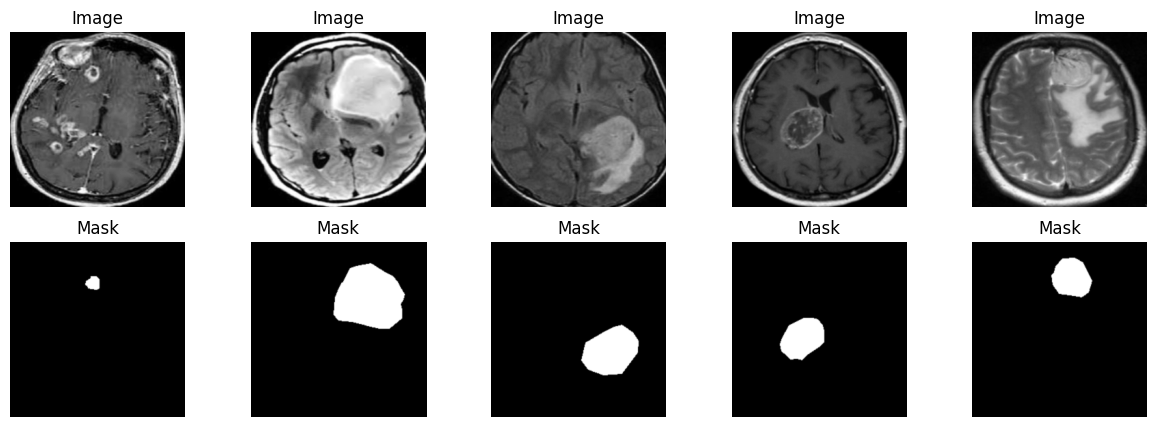

In [5]:
display_samples(images, masks)